In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


In [ ]:
X_train_scaled = pd.read_pickle('data/X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('data/X_test_scaled.pkl')
y_motor_train = pd.read_pickle('data/y_train_motor.pkl')
y_motor_test = pd.read_pickle('data/y_test_motor.pkl')
y_total_train = pd.read_pickle('data/y_train_total.pkl')
y_total_test = pd.read_pickle('data/y_test_total.pkl')

In [3]:
def build_dnn(input_dim, neurons=[160, 80, 40], dropout_rates=[0.3, 0.3, 0.2], l2_strength=0.0001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Explicit input layer
    model.add(Dense(neurons[0], activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rates[0]))
    model.add(Dense(neurons[1], activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rates[1]))
    model.add(Dense(neurons[2], activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rates[2]))
    model.add(Dense(1))  # Output layer
    return model

In [4]:
def train_and_evaluate_pre_split_val(X_train_scaled, X_test_scaled, y_train, y_test,
                                 compression_method='PCA', neuron_list=[160,80,40],
                                 batch_size=8, learning_rate=0.001,
                                 use_validation_split=True):
    
    if compression_method == 'PCA':
        pca = PCA(n_components=0.95)
        X_train_reduced = pca.fit_transform(X_train_scaled)
        X_test_reduced = pca.transform(X_test_scaled)

        explained_variance_new = pca.explained_variance_ratio_
        print(f'Variance explained by PCA: {pca.explained_variance_ratio_}')    
        plt.figure(figsize=(10,6))
        plt.bar(range(1, len(explained_variance_new)+1), explained_variance_new, alpha=0.7)
        plt.xlabel('Principal Components (PCs)')
        plt.ylabel('Proportion of Variance')
        plt.title('Variance explained by Principal Components')
        plt.grid(True)
        plt.show()

        # Cumulative variance plot
        cumulative_variance_new= np.cumsum(explained_variance_new)
        print(f'Cumulative variance explained by PCA: {cumulative_variance_new}')
        plt.figure(figsize=(10,6))
        plt.plot(range(1, len(cumulative_variance_new)+1), cumulative_variance_new, marker='o')
        plt.axhline(y=0.95, color='r', linestyle='--')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Proportion of Variance')
        plt.title('Cumulative Variance Explained')
        plt.show()
        num_pcs_95_new = np.argmax(cumulative_variance_new >= 0.95) + 1
        print(f"Number of principal components to explain 95% variance: {num_pcs_95_new}")
    # --- Autoencoder ---
    elif compression_method == 'Autoencoder':
        input_dim = X_train_scaled.shape[1]
        input_layer = Input(shape=(input_dim,))
        x = Dense(64, kernel_regularizer=regularizers.l2(1e-4))(input_layer)
        x = tf.keras.layers.LeakyReLU()(x)
        x = Dense(32, kernel_regularizer=regularizers.l2(1e-4))(x)
        x = tf.keras.layers.LeakyReLU()(x)
        encoded = Dense(8, activation='linear')(x)

        x = Dense(32, kernel_regularizer=regularizers.l2(1e-4))(encoded)
        x = tf.keras.layers.LeakyReLU()(x)
        x = Dense(64, kernel_regularizer=regularizers.l2(1e-4))(x)
        x = tf.keras.layers.LeakyReLU()(x)
        decoded = Dense(input_dim, activation='linear')(x)

        autoencoder = Model(inputs=input_layer, outputs=decoded)
        autoencoder.compile(optimizer='adam', loss='mean_squared_error')

        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
        autoencoder.fit(
            X_train_scaled, X_train_scaled,
            validation_split=0.2,
            epochs=300,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0
        )

        encoder = Model(inputs=input_layer, outputs=encoded)
        X_train_reduced = encoder.predict(X_train_scaled)
        X_test_reduced = encoder.predict(X_test_scaled)
    else:
        raise ValueError("Unknown compression method")

    if use_validation_split:
        X_train, X_val, y_train_split, y_val = train_test_split(
            X_train_reduced, y_train, test_size=0.2, random_state=42)
        val_data = (X_val, y_val)
    else:
        X_train, y_train_split = X_train_reduced, y_train
        val_data = None

    model = build_dnn(X_train.shape[1], neurons=neuron_list)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)] if use_validation_split else []

    model.fit(X_train, y_train_split,
              validation_data=val_data if val_data else None,
              epochs=1000, batch_size=batch_size,
              callbacks=callbacks, verbose=0)

    # --- Predict & Evaluate ---
    y_pred = model.predict(X_test_reduced)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return mae, rmse, r2


#### PCA+DNN (target = motor_UPDRS)

Variance explained by PCA: [0.5487172  0.18913652 0.15284804 0.07126821]


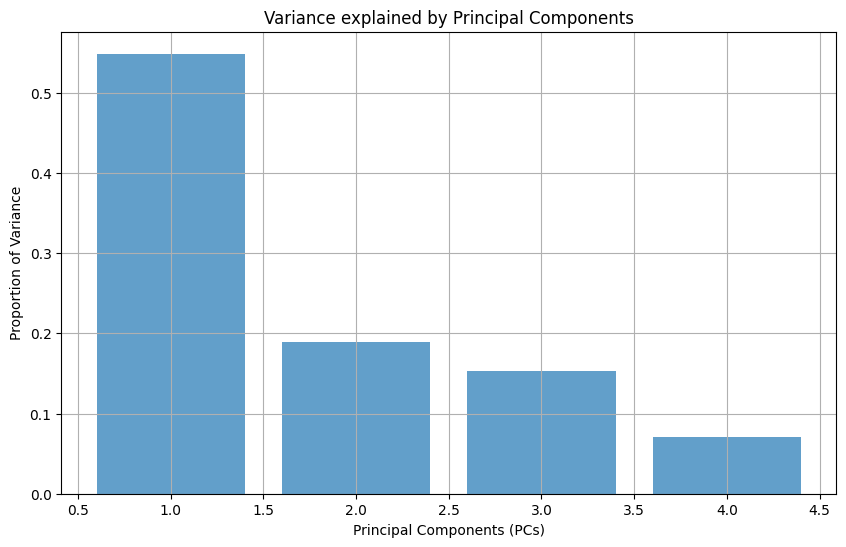

Cumulative variance explained by PCA: [0.5487172  0.73785371 0.89070175 0.96196997]


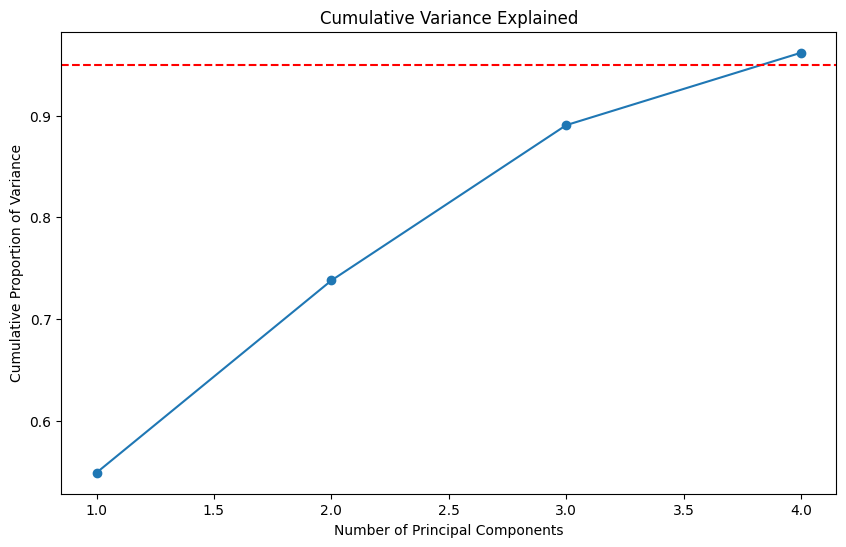

Number of principal components to explain 95% variance: 4
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
MAE: 7.671 | RMSE: 9.499 | R²: -1.808


In [5]:
mae_pca_motor, rmse_pca_motor, r2_pca_motor = train_and_evaluate_pre_split_val(
    X_train_scaled, X_test_scaled, y_motor_train, y_motor_test,
    compression_method='PCA', neuron_list=[160,80,40], use_validation_split=False
)

print(f"MAE: {mae_pca_motor:.3f} | RMSE: {rmse_pca_motor:.3f} | R²: {r2_pca_motor:.3f}")

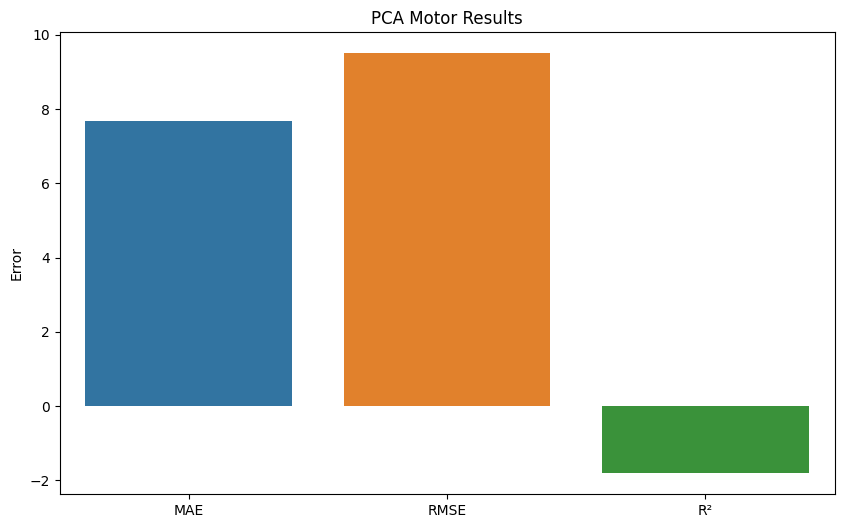

In [6]:
pca_motor_results = pd.DataFrame({
    'MAE': [mae_pca_motor],
    'RMSE': [rmse_pca_motor],
    'R²': [r2_pca_motor]
})
plt.figure(figsize=(10, 6))
sns.barplot(data=pca_motor_results)
plt.title('PCA Motor Results')
plt.ylabel('Error')
plt.show()

#### PCA+DNN (target = total_UPDRS)

Variance explained by PCA: [0.5487172  0.18913652 0.15284804 0.07126821]


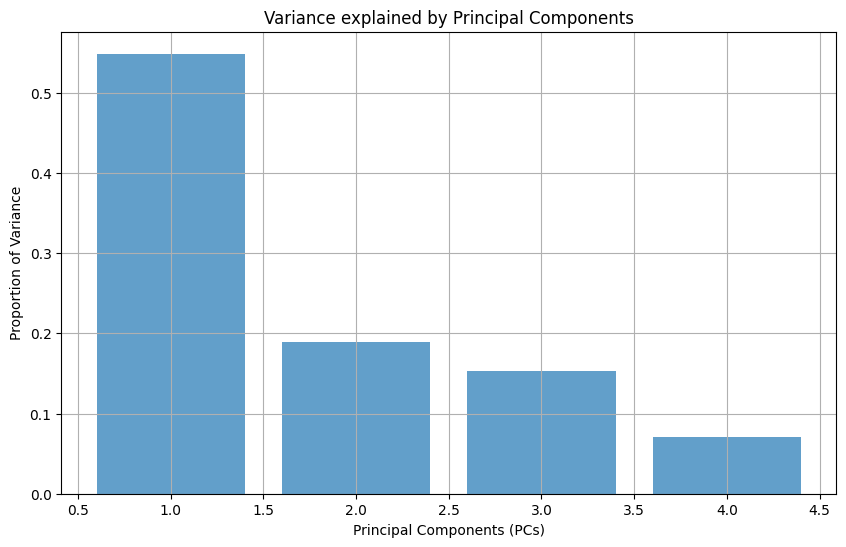

Cumulative variance explained by PCA: [0.5487172  0.73785371 0.89070175 0.96196997]


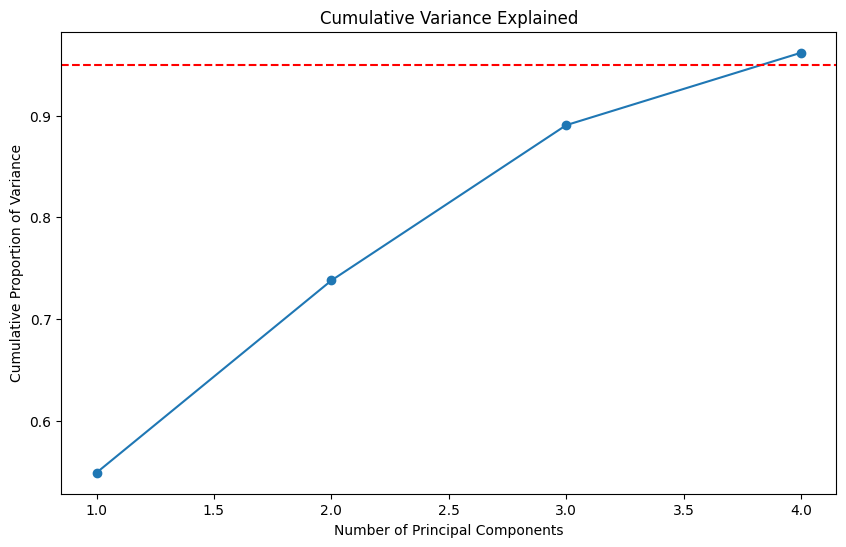

Number of principal components to explain 95% variance: 4
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
MAE: 17.085 | RMSE: 29.478 | R²: -13.903


In [7]:
mae_pca_total, rmse_pca_total, r2_pca_total = train_and_evaluate_pre_split_val(
    X_train_scaled, X_test_scaled, y_total_train, y_total_test,
    compression_method='PCA', neuron_list=[160,80,40], use_validation_split=False
)

print(f"MAE: {mae_pca_total:.3f} | RMSE: {rmse_pca_total:.3f} | R²: {r2_pca_total:.3f}")

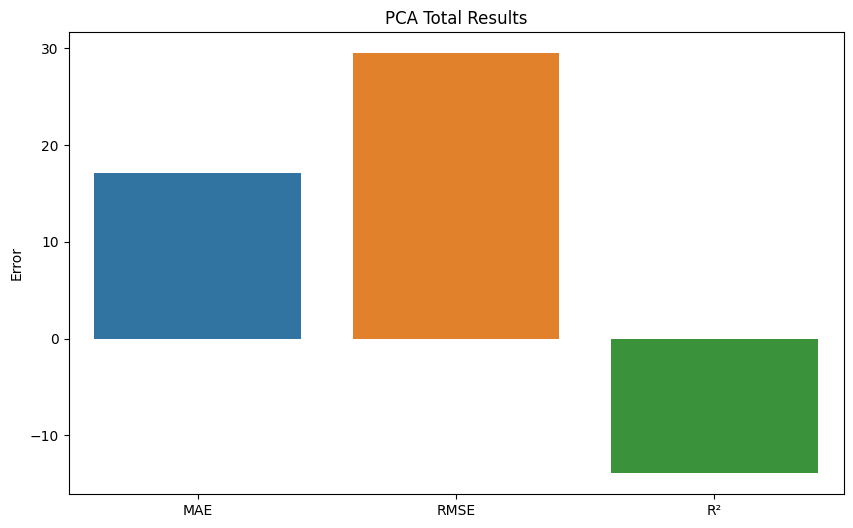

In [8]:
pca_total_results = pd.DataFrame({
    'MAE': [mae_pca_total],
    'RMSE': [rmse_pca_total],
    'R²': [r2_pca_total]
})
plt.figure(figsize=(10, 6))
sns.barplot(data=pca_total_results)
plt.title('PCA Total Results')
plt.ylabel('Error')
plt.show()

#### Autoencoder+DNN (target = motor_UPDRS)

In [9]:
mae_autoen_motor, rmse_autoen_motor, r2_autoen_motor = train_and_evaluate_pre_split_val(
    X_train_scaled, X_test_scaled, y_motor_train, y_motor_test,
    compression_method='Autoencoder', neuron_list=[160,80,40], use_validation_split=False
)

print(f"MAE: {mae_autoen_motor:.3f} | RMSE: {rmse_autoen_motor:.3f} | R²: {r2_autoen_motor:.3f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
MAE: 11.135 | RMSE: 17.418 | R²: -8.440


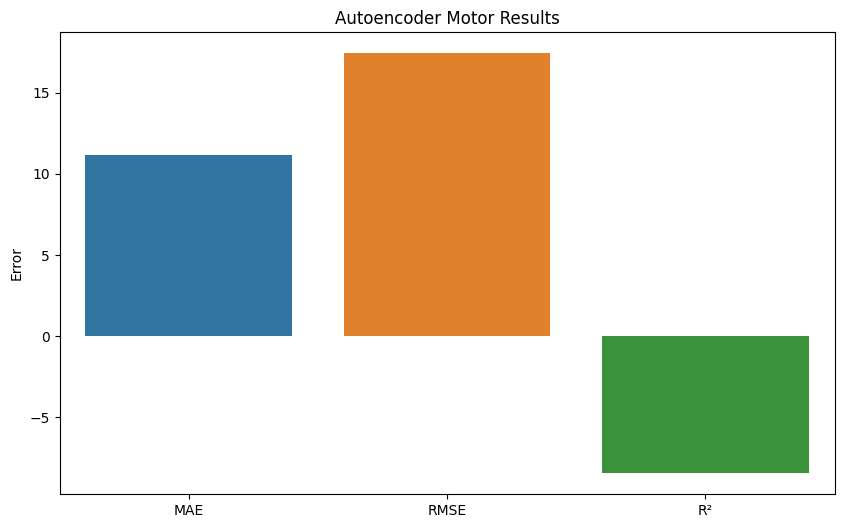

In [10]:
autoen_motor_results = pd.DataFrame({
    'MAE': [mae_autoen_motor],
    'RMSE': [rmse_autoen_motor],
    'R²': [r2_autoen_motor]
})
plt.figure(figsize=(10, 6))
sns.barplot(data=autoen_motor_results)
plt.title('Autoencoder Motor Results')
plt.ylabel('Error')
plt.show()

#### Autoencoder+DNN (target = total_UPDRS)

In [11]:
mae_autoen_total, rmse_autoen_total, r2_autoen_total = train_and_evaluate_pre_split_val(
    X_train_scaled, X_test_scaled, y_total_train, y_total_test,
    compression_method='Autoencoder', neuron_list=[160,80,40], use_validation_split=False
)

print(f"MAE: {mae_autoen_total:.3f} | RMSE: {rmse_autoen_total:.3f} | R²: {r2_autoen_total:.3f}")

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step
MAE: 13.446 | RMSE: 17.192 | R²: -4.069


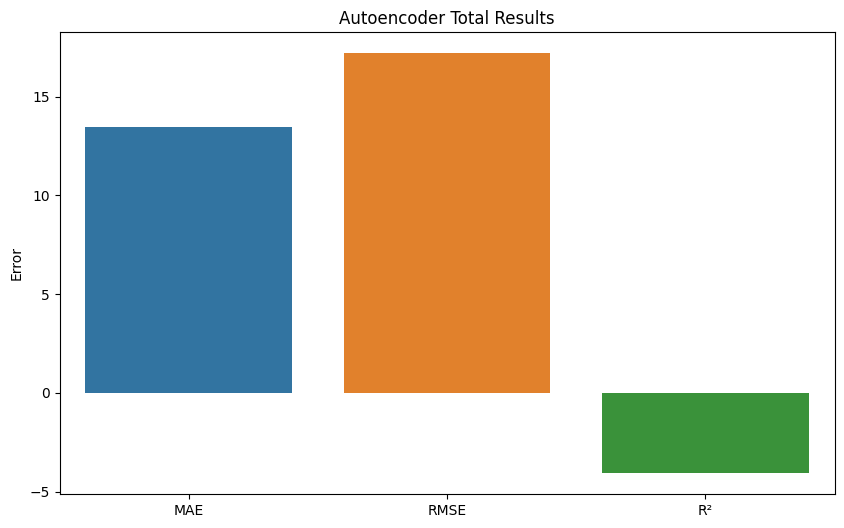

In [12]:
autoen_total_results = pd.DataFrame({
    'MAE': [mae_autoen_total],
    'RMSE': [rmse_autoen_total],
    'R²': [r2_autoen_total]
})
plt.figure(figsize=(10, 6))
sns.barplot(data=autoen_total_results)
plt.title('Autoencoder Total Results')
plt.ylabel('Error')
plt.show()


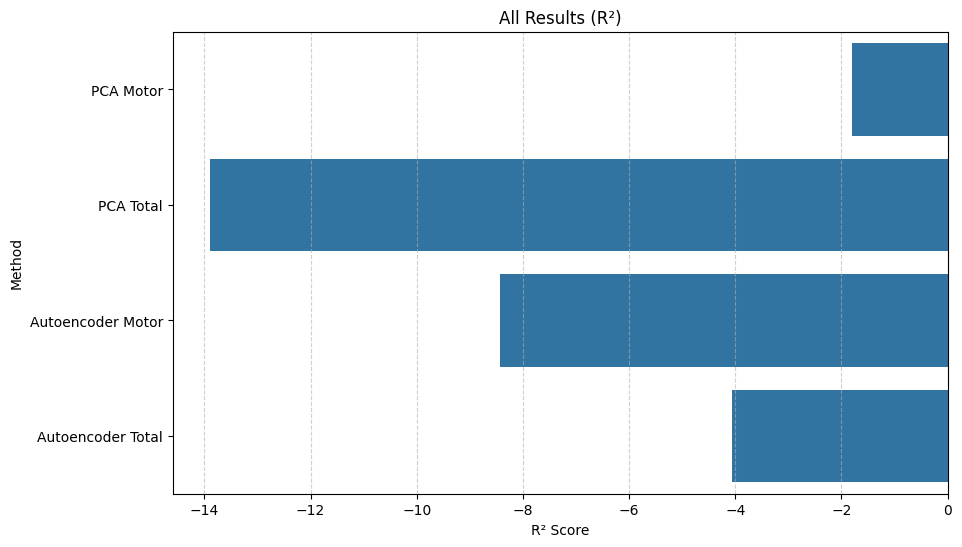

In [17]:
all_results = pd.DataFrame({
    'Metric': ['PCA Motor', 'PCA Total', 'Autoencoder Motor', 'Autoencoder Total'],
    'R²': [r2_pca_motor, r2_pca_total, r2_autoen_motor, r2_autoen_total]
})

plt.figure(figsize=(10, 6))
sns.barplot(data=all_results, x='R²', y='Metric', orient='h')
plt.title('All Results (R²)')
plt.xlabel('R² Score')
plt.ylabel('Method')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### Apply pca+NN on original dataset

In [13]:
df = pd.read_csv('data/parkinsons_updrs.data')

In [14]:
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS'])
y = df['motor_UPDRS']
groups = df['subject#']

results = []

kf = GroupKFold(n_splits=5)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X, y, groups=groups), 1):
    print(f"\nFold {fold_num}")
    # print intersection of train and test indices
    print(f"Intersection of train and test indices: {set(train_idx).intersection(set(test_idx))}")
    print(f"Number of unique groups in train indices: {len(set(groups.iloc[train_idx]))}")
    print(f"Number of unique groups in test indices: {len(set(groups.iloc[test_idx]))}")
    print()

    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = Sequential([
        Input(shape=(X_train_pca.shape[1],)),
        Dense(160, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_pca, y_train, epochs=300, batch_size=8, verbose=0)

    y_pred = model.predict(X_test_pca).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    results.append({'fold': fold_num, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

# Results summary
results_df = pd.DataFrame(results)
print("\nCross-Validation Summary:")
print(results_df)
print(f"\nAverage R²: {results_df['R²'].mean():.4f}, Average RMSE: {results_df['RMSE'].mean():.4f}")



Fold 1
Intersection of train and test indices: set()
Number of unique groups in train indices: 34
Number of unique groups in test indices: 8

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
MAE: 6.6884, RMSE: 8.8464, R²: -0.4542

Fold 2
Intersection of train and test indices: set()
Number of unique groups in train indices: 33
Number of unique groups in test indices: 9

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
MAE: 8.1776, RMSE: 9.7178, R²: -0.5005

Fold 3
Intersection of train and test indices: set()
Number of unique groups in train indices: 34
Number of unique groups in test indices: 8

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
MAE: 4.7280, RMSE: 6.0534, R²: 0.5624

Fold 4
Intersection of train and test indices: set()
Number of unique groups in train indices: 34
Number of unique groups in test indices: 8

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
MAE: 8.5710, RMSE: 10.2952, R²: -0.4846

Fold 5
Intersection of train and test indices: set()
Number of unique groups in train indices: 33
Number of

In [18]:
X = df.drop(columns=['motor_UPDRS', 'total_UPDRS'])
y = df['total_UPDRS']
groups = df['subject#']

results = []

kf = GroupKFold(n_splits=5)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X, y, groups=groups), 1):
    print(f"\nFold {fold_num}")
    # print intersection of train and test indices
    print(f"Intersection of train and test indices: {set(train_idx).intersection(set(test_idx))}")
    print(f"Number of unique groups in train indices: {len(set(groups.iloc[train_idx]))}")
    print(f"Number of unique groups in test indices: {len(set(groups.iloc[test_idx]))}")
    print()

    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_raw)
    X_test_scaled = scaler.transform(X_test_raw)

    
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model = Sequential([
        Input(shape=(X_train_pca.shape[1],)),
        Dense(160, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.3),
        Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_pca, y_train, epochs=300, batch_size=8, verbose=0)

    y_pred = model.predict(X_test_pca).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")
    results.append({'fold': fold_num, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

# Results summary
results_df = pd.DataFrame(results)
print("\nCross-Validation Summary:")
print(results_df)
print(f"\nAverage R²: {results_df['R²'].mean():.4f}, Average RMSE: {results_df['RMSE'].mean():.4f}")


Fold 1
Intersection of train and test indices: set()
Number of unique groups in train indices: 34
Number of unique groups in test indices: 8

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
MAE: 10.3703, RMSE: 13.5360, R²: -0.7161

Fold 2
Intersection of train and test indices: set()
Number of unique groups in train indices: 33
Number of unique groups in test indices: 9

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
MAE: 12.5128, RMSE: 15.0793, R²: -0.6896

Fold 3
Intersection of train and test indices: set()
Number of unique groups in train indices: 34
Number of unique groups in test indices: 8

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
MAE: 7.3637, RMSE: 8.7184, R²: 0.3040

Fold 4
Intersection of train and test indices: set()
Number of unique groups in train indices: 34
Number of unique groups in test indices: 8

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
MAE: 11.0905, RMSE: 12.6629, R²: -0.4249

Fold 5
Intersection of train and test indices: set()
Number of unique groups in train indices: 33
Numb